# TRANSFER LEARNING CLASSIFICATION 

## Step 1: Import required packages

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import feature # This pacakge is used for LBP feature extraction
from sklearn.utils import shuffle
from sklearn import metrics 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
%matplotlib inline
import cv2
import seaborn as sns # This pacakge is used for better visualization of data (e.g confusion matrix)
import tensorflow as tf
import os
import zipfile
%load_ext tensorboard
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model               

In [ ]:
root_dir = '/kaggle/input/state-farm-distracted-driver-detection/'
working_dir = '/kaggle/working'
model_dir = os.path.join(working_dir,"model")
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
checkpoint_dir = os.path.join(working_dir,"checkpoint")
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

In [ ]:
ls

__notebook_source__.ipynb  checkpoint/  model/


In [ ]:
%cd /kaggle/input/state-farm-distracted-driver-detection/imgs/

/kaggle/input/state-farm-distracted-driver-detection/imgs


## Step 2. Dataset preparation

In [ ]:
base_dir = '/kaggle/input/state-farm-distracted-driver-detection/imgs'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Directory with our training c0 pictures
train_c0_dir = os.path.join(train_dir, 'c0')
# Directory with our training c1 pictures
train_c1_dir = os.path.join(train_dir, 'c1')
# Directory with our training c2 pictures
train_c2_dir = os.path.join(train_dir, 'c2')
# Directory with our training c3 pictures
train_c3_dir = os.path.join(train_dir, 'c3')
# Directory with our training c4 pictures
train_c4_dir = os.path.join(train_dir, 'c4')
# Directory with our training c5 pictures
train_c5_dir = os.path.join(train_dir, 'c5')
# Directory with our training c6 pictures
train_c6_dir = os.path.join(train_dir, 'c6')
# Directory with our training c7 pictures
train_c7_dir = os.path.join(train_dir, 'c7')
# Directory with our training c8 pictures
train_c8_dir = os.path.join(train_dir, 'c8')
# Directory with our training c9 pictures
train_c9_dir = os.path.join(train_dir, 'c9')

In [ ]:
if not os.path.exists(test_dir):
    print("Testing data does not exists")
if not os.path.exists(train_dir):
    print("Training data does not exists")

In [ ]:
img_path = os.path.join(train_dir, "c0/img_34.jpg")
print(img_path)
# Read the image
image = cv2.imread(img_path)
print(image.shape)

/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c0/img_34.jpg
(480, 640, 3)


### Getting info from csv file

In [ ]:
data_train = pd.read_csv(os.path.join(root_dir, "driver_imgs_list.csv"))
data_train.info()
data_train['classname'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22424 entries, 0 to 22423
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subject    22424 non-null  object
 1   classname  22424 non-null  object
 2   img        22424 non-null  object
dtypes: object(3)
memory usage: 525.7+ KB


c0    2489
c3    2346
c4    2326
c6    2325
c2    2317
c5    2312
c1    2267
c9    2129
c7    2002
c8    1911
Name: classname, dtype: int64

## Step 3:  Using ResNet50
Input: $224 X 224 X 3$ image

In [ ]:
from keras.applications.resnet50 import ResNet50
# Load the ResNet50 model with pretrained weights
resnet50_model = ResNet50(weights='imagenet')
#Flatten output layer of Resnet
flattened = tf.keras.layers.Flatten()(resnet50_model.output)
#Dense layer 1
densed1 = tf.keras.layers.Dense(512, activation='relu')(flattened)
#Dense layer 1    
densed2 = tf.keras.layers.Dense(10, activation='softmax')(densed1)

model = tf.keras.models.Model(inputs=resnet50_model.input, outputs=densed2)
model.summary()

102973440/102967424 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['acc'])

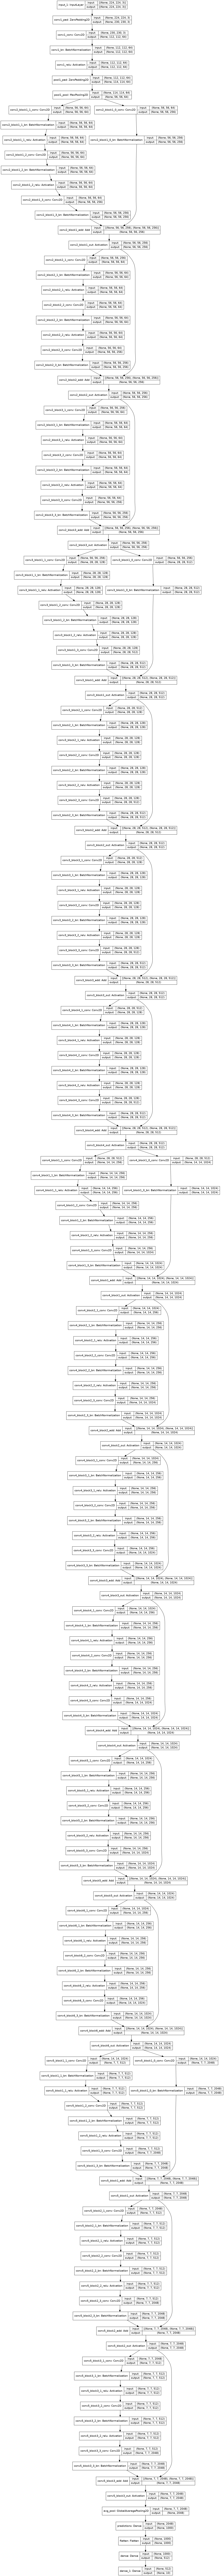

In [ ]:
plot_model(model,to_file=os.path.join(model_dir,"transferlearningmodel_distracted_driver.png"),show_shapes=True,show_layer_names=True)

## Step 4:  Training CNN with ImageDataGenerator

In [ ]:
# Updated to do image augmentation
train_datagen = ImageDataGenerator(
      rescale=1./255,
      validation_split=0.2)

test_datagen = ImageDataGenerator(
      rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir, # This is the source directory for training images
        subset='training',
        target_size=(224, 224),  # All images will be resized to 224x224
        batch_size=20,
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = train_datagen.flow_from_directory(
        train_dir,
        subset='validation',
        target_size=(224, 224),
        batch_size=20,
        class_mode='categorical')

Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


### Saving the snapshot of model as checkpoint

### Training the model

In [ ]:
history = model.fit_generator(
      train_generator,
      epochs=5,
      validation_data=validation_generator,
      callbacks = [checkpoint],
      verbose=2)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
898/898 - 277s - loss: 1.4695 - acc: 0.7669 - val_loss: 0.6338 - val_acc: 0.8358
Epoch 2/5
898/898 - 158s - loss: 0.3167 - acc: 0.8721 - val_loss: 0.2227 - val_acc: 0.8822
Epoch 3/5
898/898 - 158s - loss: 0.2059 - acc: 0.8834 - val_loss: 0.1901 - val_acc: 0.8873
Epoch 4/5
898/898 - 158s - loss: 0.1809 - acc: 0.8902 - val_loss: 0.2465 - val_acc: 0.8770
Epoch 5/5
898/898 - 158s - loss: 0.1714 - acc: 0.8958 - val_loss: 0.2601 - val_acc: 0.8768


## Step 5:  Visualization of results

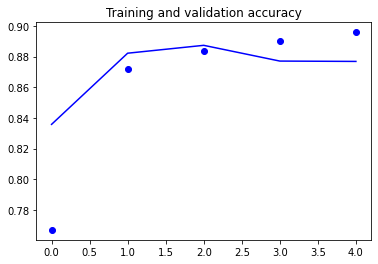

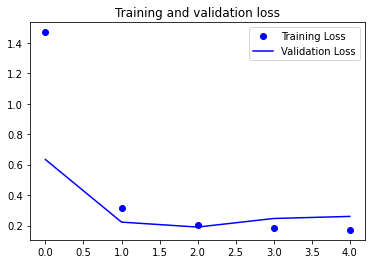

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Step 6: Applying model on test dataset

In [ ]:
import glob
from PIL import Image 
def load_data(fpath):    
    # Resize images to 150x150 for CNN compatibility
    img = Image.open(fpath).resize((224,224)) 
    img = np.asarray(img, dtype='float32') / 255.
    return img

TEST_IMAGE_PATHS = glob.glob(os.path.join(test_dir, "*.*"))
images = []
for file_path in TEST_IMAGE_PATHS[:1000]:
    images.append(load_data(file_path))
    
images = np.asarray(images)
images.shape

(1000, 224, 224, 3)

In [ ]:
# Evaluate on 1000 images
import time
start = time.time()
result = model.predict(images)
end = time.time()
print("Processed time = ", end-start)

Processed time =  3.386786460876465
